# Dépenses de consommation trimestrielles des ménages

## Importation des packages et des données

In [87]:
%matplotlib inline
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
#from mlxtend.plotting import plot_pca_correlation_graph
import os
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pyfile import *
cwd = os.getcwd()

yty_var_tot = pd.DataFrame({'Variations de la consommation':var, 'Date':list(conso.index)[4:]})
yty_var_tot = yty_var_tot.set_index('Date').loc['2011T1':]
yty_var_tot = yty_var_tot.diff().iloc[1:,:]
yty_var_tot.index = lesdates[np.arange(2,len(lesdates),3)]

X_selectb = (X[selectionBrut].iloc[:118,:][::-1].diff(periods=12)/X[selectionBrut].iloc[:118,:][::-1].shift(periods=12)).diff(periods=1).iloc[13:,:] # On prend une période de plus
X_selectb.index = lesdates

Y_train = yty_var_tot.iloc[:25]
Y_test = yty_var_tot.iloc[25:]
X_train = X_selectb.iloc[:75,:]
X_test = X_selectb.iloc[75:,:]

yty_var_tot3 = pd.DataFrame()
for i in range(len(X_selectb)):
    yty_var_tot3[i] = pd.Series(np.float64(yty_var_tot.iloc[i//3]))
yty_var_tot3 = yty_var_tot3.T
yty_var_tot3.index = X_selectb.index
yty_var_tot3 = pd.Series(yty_var_tot3[0])

## Modèle AR(8)

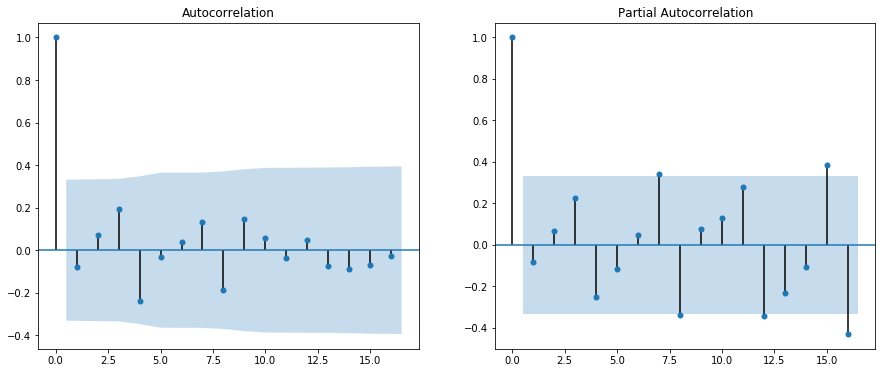

In [88]:
''' Plot des autocorrélations '''

figgg, axxxs = plt.subplots(1,2,figsize=(15,6))
plot_acf(yty_var_tot, ax=axxxs[0])
plot_pacf(yty_var_tot, ax=axxxs[1])
plt.show() # On voit qu'on peut essayer les modèles AR(8), AR(12) et AR(16)
figgg.savefig('Images/acfyty.png')

In [89]:
''' Ajustement des modèles '''

AR8 = sm.tsa.SARIMAX(yty_var_tot, order=(8,0,0)).fit(disp=False)
AR12 = sm.tsa.SARIMAX(yty_var_tot, order=(12,0,0)).fit(disp=False)
AR16 = sm.tsa.SARIMAX(yty_var_tot, order=(16,0,0)).fit(disp=False)

epsilon2 = AR8.resid
ar8_error = (epsilon2**2).sum()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % fre

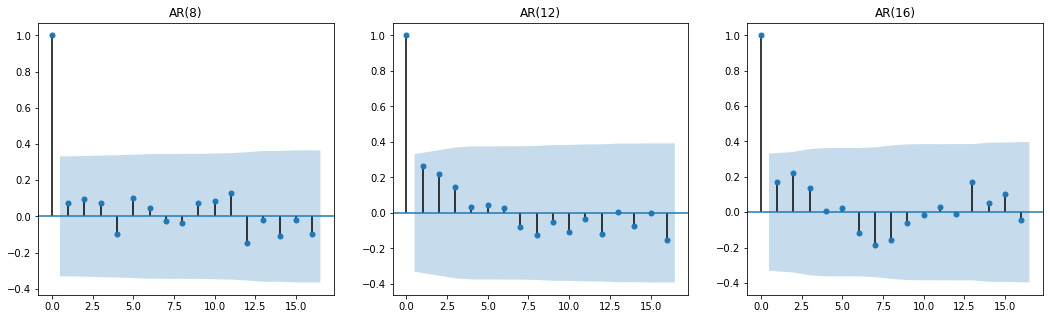

-240.07332927268197 -228.20198266202755 -218.99064907181298


In [90]:
''' Plot des autocorrélations des résidus, BIC respectifs '''

figure, axe = plt.subplots(1,3,figsize=(18,5))

plot_acf(AR8.resid,ax=axe[0],title='AR(8)')
plot_acf(AR12.resid,ax=axe[1],title='AR(12)')
plot_acf(AR16.resid,ax=axe[2],title='AR(16)')

plt.show()
figure.savefig('Images/residwhiteness.png')
print(AR8.bic, AR12.bic, AR16.bic)

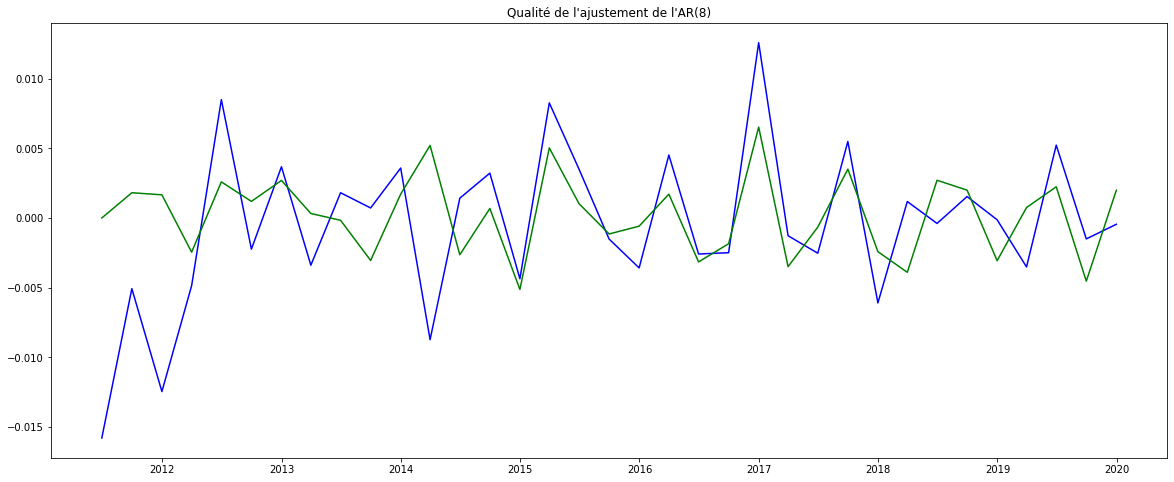

In [91]:
arpredict = AR8.get_prediction()
figure, axe = plt.subplots(figsize=(20,8))
axe.plot(yty_var_tot, color='blue', label='Actual')
axe.plot(arpredict.predicted_mean, color='green',label='AR(8)')
axe.set_title('Qualité de l\'ajustement de l\'AR(8)')
plt.show()
figure.savefig('Images/adjustar.png')

## Échantillonnage de données mélangées, sans contraintes
Unconstrained mixed data sampling - UMIDAS

Soit $t$ dénotant les mois. Les trimestres sont donc dénotés par $3t$. Les séries doivent être stationnaires.

\begin{align*}

Y_{3t} = \alpha + \Phi(B)Y_{3t} + \beta(B)X_{3t}^{'} + \epsilon_t
\\
\text{où :} 
\left\{\begin{array} \, X_t = & (X_{1,t}, \cdots, X_{k,t})
\\
\Phi(B) = & \sum_{i=1}^{p} \Phi_i B^{3i}
\\
\beta(B) = & (\sum_{i=0}^{3p} \beta_{i,1} B^i , \cdots, \sum_{i=0}^{3p} \beta_{i,k} B^i)
\end{array} \right.

\end{align*}

Estimation par MCO : 

\begin{align*}

\hat{\alpha}_{MCO}, \hat{\Phi}_{MCO},\hat{\beta}_{MCO} = \underset{\alpha, \Phi, \beta}{arg min} \sum_{t=p}^T (Y_{3t} - \alpha - \Phi(B)Y_{3t} - \beta(B)X_{3t}^{'})^2

\end{align*}

En posant : 

\begin{align*}

Z_{3t} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})

\end{align*}

Le problème se réécrit :

\begin{align*}

\underset{\omega \in \mathbb{R}^{1 + p + k(3p+1)}}{arg min} \sum_{t=p}^{T} (Y_{3t} - \omega Z_{3t}^{'} )^2

\end{align*}

Il y a une solution explicite :

\begin{align*}

\hat{\omega}_{MCO} = \mathbb{E}[Z_{3t}^{'} Z_{3t}]^{-1} \mathbb{E}[Z_{3t}^{'}Y_{3t}] \approx (\sum_{t=p}^T Z_{3t}^{'} Z_{3t})^{-1} \sum_{t=p}^TZ_{3t}^{'}Y_{3t}

\end{align*}

Ainsi la prévision nowcast devient :

\begin{align*}

\hat{Y}_{3t + 3} = \hat{\omega}_{MCO} Z_{3t + 3}^{'}

\end{align*}

### Que fait-on lorsque nous n'avons pas tous les mois du trimestre ?

Les données passent de $Z_{3t} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})$ à $Z_{3t,mois} = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t} \mathbb{1}_{\% 3 \leq mois}(3t),X_{1,3t-1}\mathbb{1}_{\% 3 \leq mois}(3t - 1),\cdots, X_{1,3t-3p} \mathbb{1}_{\% 3 \leq mois}(3t-3p),X_{2,3t} \mathbb{1}_{\% 3 \leq mois}(3t),\cdots, X_{k,3t-3p}\mathbb{1}_{\% 3 \leq mois}(3t-3p))$ où \% désigne le reste de la division euclidienne, et où une valeur constante nulle signifie une absence de donnée.

Une idée peut être de d'abord faire une régression (AR(3p)) des mois suivants en fonction des mois précédents de chaque variable explicative.

On prévoit alors ainsi :

\begin{align*}

\hat{Y}_{3t + 3} = \hat{\omega}_{MCO} \tilde{Z}_{3t + 3}^{'}

\end{align*}

avec $\tilde{Z}_{3t + 3}^{'}$ le vecteur $Z_{3t,mois}$ où l'on a remplacé les zéros par la prédiction par AR(3p) des valeurs manquantes.

In [92]:
''' Calcul de omega '''

p = 4 # On fixe l'ordre de régression p, il faudrait enquêter sur les autocorrélations
k = len(X_selectb.columns)

Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
for t in np.arange(p,len(yty_var_tot)):
    z = [1]
    for i in np.arange(1,p): # On rajoute les Y_3(t-i)
        z.append(np.float64(yty_var_tot.iloc[t-i]))
    for j in range(k): # On rajoute les X_3t-i
        for l in np.arange(0,3*p):
            z.append(np.float64(X_selectb.iloc[(3*t)-l,j])) # Vérifier qu'on a les bons index
    Z[t] = pd.Series(z)

sumdesign = Z @ Z.T
inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) # Ensuite, on calcule la somme des matrices de design et son inverse
secondfactor = pd.DataFrame(Z.values @ yty_var_tot.iloc[p:].values) # On calcule également la somme des produits Z_3t' par Y_3t

omega = inv_sumdesign @ secondfactor # On multiplie l'inverse de la somme des matrices de design par la somme des produits.

Pour vérifier l'efficacité, on calcule les résidus $Y_{mois} - \hat{\omega} Z_{mois}$

In [93]:
''' Calcul des résidus sur l'échantillon d'entraînement '''

fcst = pd.DataFrame()
for t in np.arange(p,len(yty_var_tot)):
    fcst[t] = omega.T @ Z[t]

fcst = fcst.T
fcst.index = yty_var_tot.index[p:]

epsilon = yty_var_tot['Variations de la consommation'] - fcst[0]

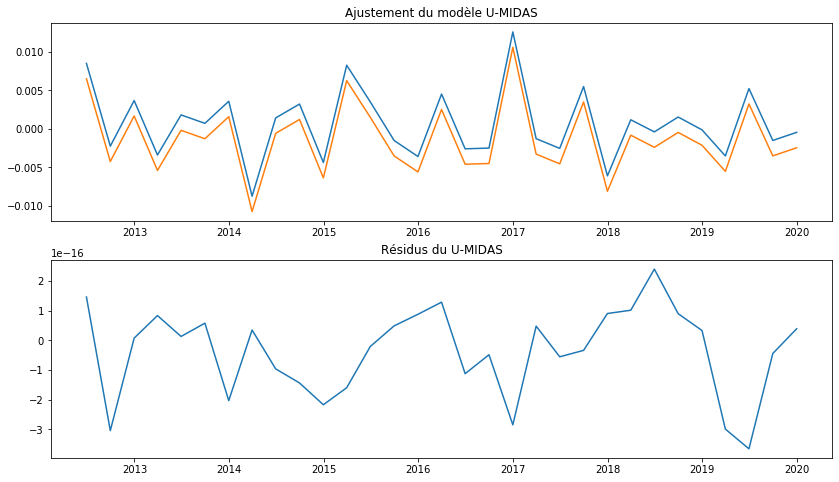

In [94]:
figure, axe = plt.subplots(2,1,figsize=(14,8))
axe[0].plot(fcst.index, fcst)
axe[0].plot(fcst.index, yty_var_tot[p:]-0.002) # On décale un tout petit peu pour voir qqch
axe[0].set_title("Ajustement du modèle U-MIDAS")
axe[1].plot(epsilon)
axe[1].set_title("Résidus du U-MIDAS")
plt.show()

On remarque que le modèle "fit" très bien aux données. Aussi, nous nous sommes placés dans un cadre optimal ou la seule information non disponible est $Y_t$. Nous allons déjà comparer ce modèle à un modèle "naïf" de type ARMA. Ensuite, nous allons étudier le modèle UMIDAS lorsque nous n'avons pas toutes les informations sur les $X_t$.

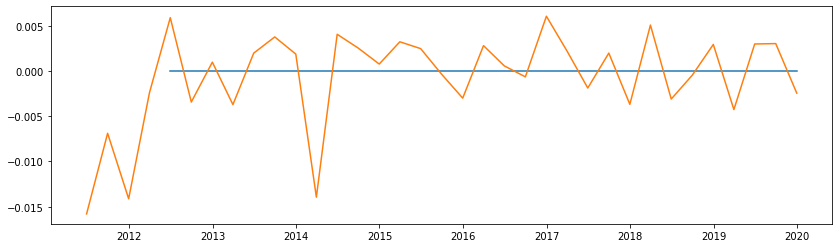

In [95]:
figure, axe = plt.subplots(figsize=(14,4))
axe.plot(epsilon)
axe.plot(epsilon2)
#axe.set_yscale('log')
plt.show()

Le UMIDAS est clairement plus performant que le modèle AR sur la période étudiée. Toutefois, il s'agit d'un échantillon d' "entraînement". Nous allons étudier les modèles sur des échantillons train et test séparés.

Une approche, dite "directe" (cf. Marcellino et al, 2006), est de recalculer les coefficients de la régression pour chaque différents cas (lorsqu'il nous manque 3 mois, 2 mois, 1 mois ou aucun mois). Aussi, là-dessus nous allons ajuster un modèle de régression pour chacun de ces cas. Toutefois, nous allons aussi observer le comportement du modèle dans un cadre dynamique, lorsqu'on ajuste les coefficients au cours du temps avec les nouvelles données.

#### Ajustement des différents $\omega$ pour différentes situations de données manquantes.

Il s'agit de recalculer les coefficients avec 

\begin{align*}

Z_{3t,0} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t-3},X_{1,3t-4},\cdots, X_{1,3t-3p},X_{2,3t-3},\cdots, X_{k,3t-3p})
\\ Z_{3t,1} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t-2},X_{1,3t-3},\cdots, X_{1,3t-3p},X_{2,3t-2},\cdots, X_{k,3t-3p})
\\ Z_{3t,2} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t-1},X_{1,3t-2},\cdots, X_{1,3t-3p},X_{2,3t-1},\cdots, X_{k,3t-3p})
\\ Z_{3t,3} & = (1,Y_{3(t-1)}, \cdots, Y_{3(t-p)}, X_{1,3t},X_{1,3t-1},\cdots, X_{1,3t-3p},X_{2,3t},\cdots, X_{k,3t-3p})
\end{align*}

pour chaque $Z_{3t,\text{mois disponibles}}$.

In [128]:
p = 3 # On fixe l'ordre de régression p, il faudrait enquêter sur les autocorrélations
k = len(X_selectb.columns)

Zs = []
omegas = []
for situation in range(4):

    Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
    for t in np.arange(p,len(Y_train)):
        z = [1]
        for i in np.arange(1,p): # On rajoute les Y_3(t-i)
            z.append(np.float64(Y_train.iloc[t-i]))
        for j in range(k): # On rajoute les X_3t-i
            for l in np.arange(0,3*p):
                z.append(np.float64(X_train.iloc[(3*t)-situation-l,j])) # Vérifier qu'on a les bons index
        Z[t] = pd.Series(z)
    Zs.append(Z)
    sumdesign = Z @ Z.T
    inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) # Ensuite, on calcule la somme des matrices de design et son inverse
    secondfactor = pd.DataFrame(Z.values @ Y_train.iloc[p:].values) # On calcule également la somme des produits Z_3t' par Y_3t

    omega = inv_sumdesign @ secondfactor
    omegas.append(omega)

Zstest = []
for situation in range(4):

    Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
    for t in np.arange(len(Y_train),len(yty_var_tot)):
        z = [1]
        for i in np.arange(1,p): # On rajoute les Y_3(t-i)
            z.append(np.float64(yty_var_tot.iloc[t-i]))
        for j in range(k): # On rajoute les X_3t-i
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selectb.iloc[(3*t)-situation-l,j])) # Vérifier qu'on a les bons index
        Z[t] = pd.Series(z)
    Zstest.append(Z)

TypeError: float() argument must be a string or a number, not 'RegressionResultsWrapper'

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


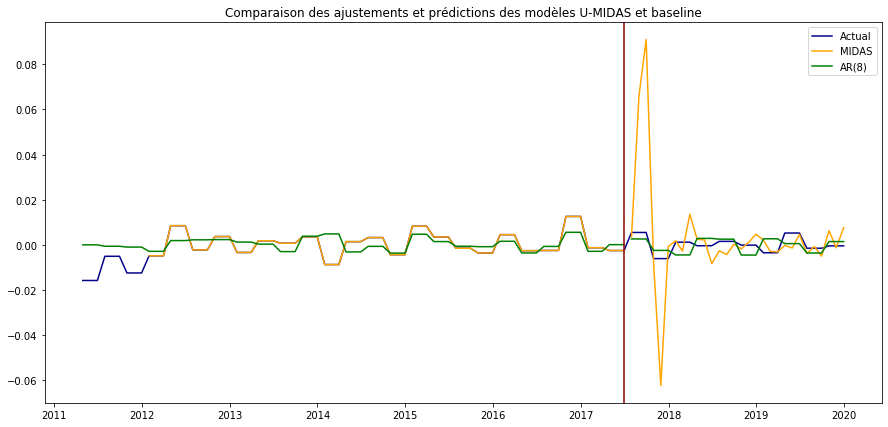

In [97]:
toplot = []

for t in np.arange(p,len(Y_train)):
    for situation in range(3):
        toplot.append(Zs[2-situation][t] @ omegas[2-situation])

toreallyplot = pd.Series([toplot[i][0] for i in range(len(toplot))])
toreallyplot.index = X_train.index[3*p:]

toplot2 = []

for t in range(len(yty_var_tot)-len(Y_train)):
    for situation in range(3):
        toplot2.append(Zstest[2-situation].iloc[:,t] @ omegas[2-situation])

toreallyplot2 = pd.Series([toplot2[i][0] for i in range(len(toplot2))])
toreallyplot2.index = X_test.index


AR8 = sm.tsa.SARIMAX(Y_train, order=(8,0,0)).fit()
artrainprediction = AR8.get_prediction().predicted_mean
artestprediction = AR8.get_forecast(steps=len(Y_test)).predicted_mean

liste1 = []
liste2 = []
for elt in artrainprediction:
    for i in range(3):
        liste1.append(elt)

for elt in artestprediction:
    for i in range(3):
        liste2.append(elt)

artrainprediction = pd.Series(liste1)
artestprediction = pd.Series(liste2)
artrainprediction.index = X_train.index
artestprediction.index = X_test.index


figure, axe = plt.subplots(figsize=(15,7))
axe.plot(yty_var_tot3, color='darkblue', label='Actual')
axe.plot(toreallyplot, color='orange', label='MIDAS')
axe.plot(toreallyplot2, color='orange')
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.axvline(Y_train.index[-1], color = 'darkred')
axe.set_title("Comparaison des ajustements et prédictions des modèles U-MIDAS et baseline")
plt.legend()
plt.show()


## SARIMA avec variables exogènes


In [98]:
''' Aggrégation des variables explicatives en moyennant sur les trimestres '''
# SARIMAX permet de faire un tel modèle
X_selectb_agg = pd.DataFrame([X_selectb.iloc[3*i:3*(i+1),:].mean() for i in range(len(yty_var_tot))], index=yty_var_tot.index)

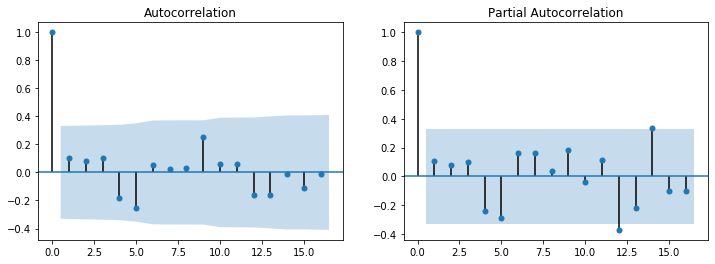

In [99]:
''' On regarde les ordres p et q à appliquer au modèle SARIMAX en enquêtant sur les autocorrélations des résidus de la régression de Y sur X '''

residus = sm.OLS(yty_var_tot,X_selectb_agg).fit().resid

figure, axe = plt.subplots(1,2,figsize=(12,4))
plot_acf(residus,ax=axe[0])
plot_pacf(residus,ax=axe[1]) # On choisit un ARMAX(1,1)
plt.show()
figure.savefig('Images/acfarmax.png')

In [100]:
''' On ajuste le modèle '''
sarima = sm.tsa.SARIMAX(Y_train,X_selectb_agg.iloc[:len(Y_train),:],order=(12,0,0)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


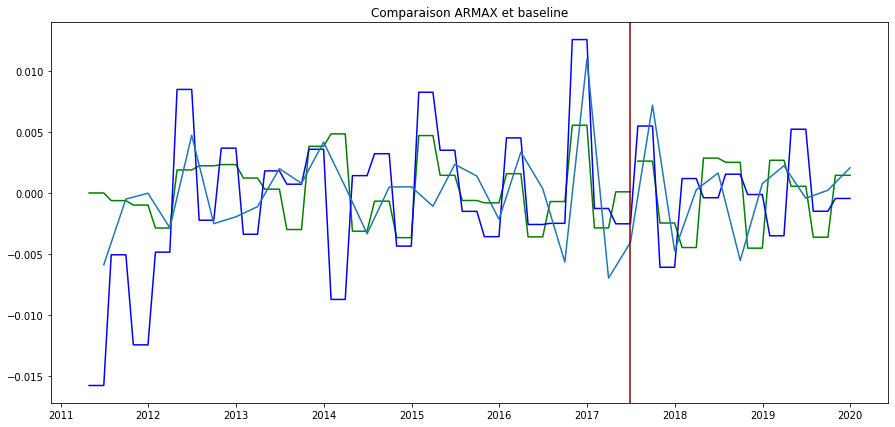

In [101]:
figure, axe = plt.subplots(figsize=(15,7))
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.plot(yty_var_tot3, color='blue', label='Actual')
axe.plot(sarima.get_prediction(start=0,end=34,
endog=yty_var_tot,
exog=X_selectb_agg.iloc[len(Y_train):,:]).predicted_mean, label='ARMAX(1,1)')
axe.axvline(Y_train.index[-1], color = 'darkred')
axe.set_title('Comparaison ARMAX et baseline')
plt.show()

## VAR

In [102]:
time_averaging = pd.DataFrame()
nombre_lags = 8
compteur=0

for i,col in enumerate(X_selectb_agg.columns):
    time_averaging[compteur] = X_selectb_agg.iloc[:,i]
    compteur += 1
    if nombre_lags != 0:
        for l in range(nombre_lags):
            time_averaging[compteur] = X_selectb_agg.iloc[:,i].shift(l+1)
            compteur += 1

time_averaging = time_averaging.iloc[nombre_lags:,:]

y_lags = pd.DataFrame()
if nombre_lags != 0:
    for l in range(nombre_lags):
        y_lags[l+1] = yty_var_tot.shift(l+1).iloc[:,0]

y_lags = y_lags.iloc[nombre_lags:,:]

if nombre_lags == 0:
    regressors = time_averaging
else:
    regressors = pd.concat([y_lags,time_averaging],axis=1)
regressors = sm.add_constant(regressors)

In [103]:
var = sm.OLS(Y_train.iloc[nombre_lags:], regressors.iloc[:len(Y_train)-nombre_lags,:]).fit()

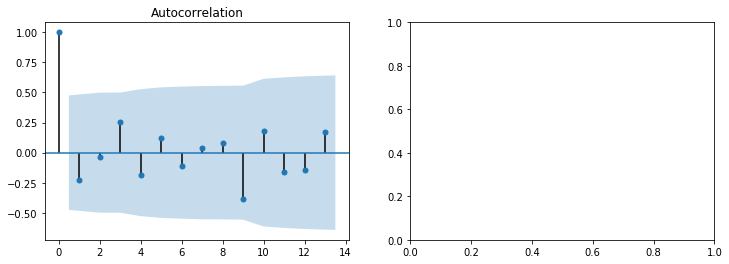

In [104]:
''' On vérifie la blancheur des résidus en regardant les autocorrélations '''

residus = var.resid

figure, axe = plt.subplots(1,2,figsize=(12,4))
plot_acf(residus,ax=axe[0])
plt.show()

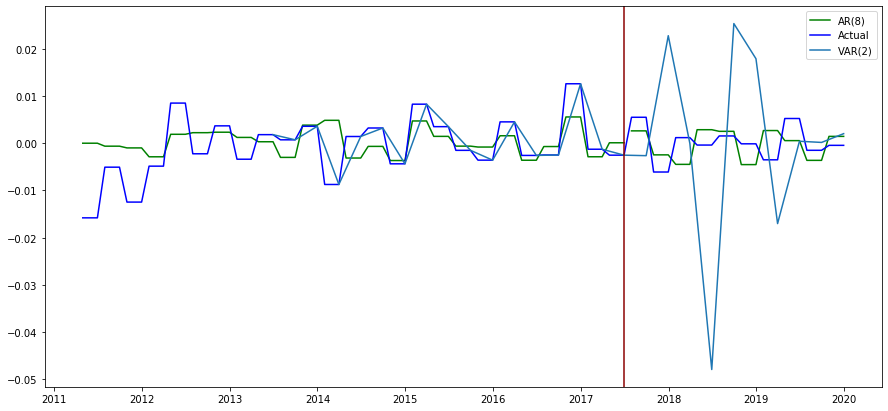

In [105]:
figure, axe = plt.subplots(figsize=(15,7))
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.plot(yty_var_tot3, color='blue', label='Actual')
axe.plot(var.predict(regressors), label='VAR(2)')
axe.axvline(Y_train.index[-1], color = 'darkred')
plt.legend()
plt.show()

## Comparaison de tous les modèles

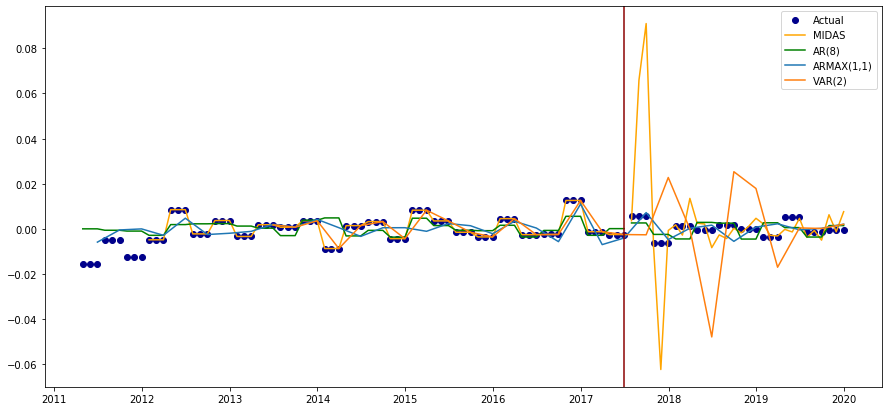

In [106]:
figure, axe = plt.subplots(figsize=(15,7))

axe.plot(yty_var_tot3, marker = 'o', linestyle='', color='darkblue', label='Actual')
axe.plot(toreallyplot, color='orange', label='MIDAS')
axe.plot(toreallyplot2, color='orange')
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.plot(sarima.get_prediction(start=0,end=34,
endog=yty_var_tot,
exog=X_selectb_agg.iloc[len(Y_train):,:]).predicted_mean, label='ARMAX(1,1)')
axe.plot(var.predict(regressors), label='VAR(2)')
axe.axvline(Y_train.index[-1], color = 'darkred')
#axe.set_ylim([-0.015,0.018])

plt.legend()
plt.show()
figure.savefig('modelsforecasts.png')

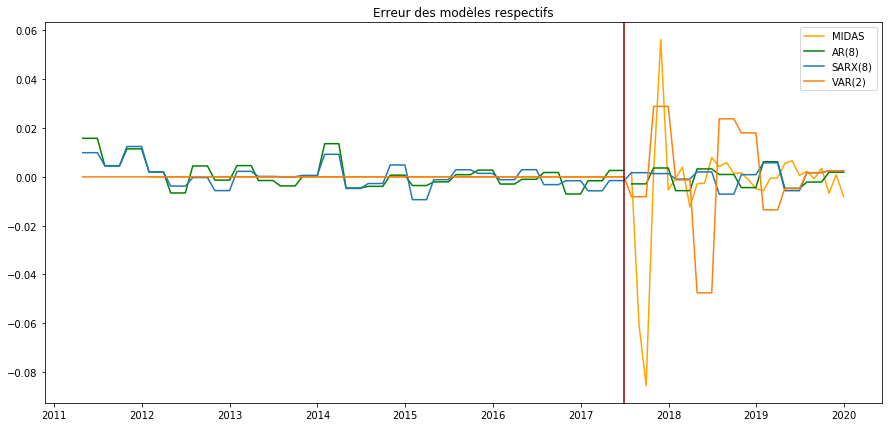

In [107]:
figure, axe = plt.subplots(figsize=(15,7))

axe.plot(yty_var_tot3.iloc[len(yty_var_tot3) - len(toreallyplot2) - len(toreallyplot):len(yty_var_tot3) - len(toreallyplot2)] - toreallyplot, color='orange', label='MIDAS')
axe.plot((yty_var_tot3 - toreallyplot2).dropna(), color='orange')
axe.plot(artrainprediction-yty_var_tot3, color='green' , label='AR(8)')
axe.plot(artestprediction-yty_var_tot3, color='green')
axe.plot((sarima.get_prediction(start=0,end=34, endog=yty_var_tot,exog=X_selectb_agg.iloc[len(Y_train):,:]).predicted_mean-yty_var_tot3).bfill(), label='SARX(8)')

axe.plot((var.predict(regressors)-yty_var_tot3).bfill(), label='VAR(2)')

axe.axvline(Y_train.index[-1], color = 'darkred')

axe.set_title("Erreur des modèles respectifs")
plt.legend()
plt.show()
figure.savefig('modelserrors.png')

In [108]:

train_mse_midas = ((yty_var_tot3.iloc[len(yty_var_tot3) - len(toreallyplot2) - len(toreallyplot):len(yty_var_tot3) - len(toreallyplot2)] - toreallyplot)**2).mean()
test_mse_midas = (((yty_var_tot3 - toreallyplot2).dropna())**2).mean()

train_mse_ar = (((artrainprediction-yty_var_tot3).dropna())**2).mean()
test_mse_ar = (((artestprediction-yty_var_tot3).dropna())**2).mean()

train_mse_sarx = ((sarima.get_prediction(start=0,end=34, endog=yty_var_tot,exog=X_selectb_agg.iloc[len(Y_train):,:]).predicted_mean-yty_var_tot3).bfill().iloc[:len(X_train)]**2).mean()

test_mse_sarx = ((sarima.get_prediction(start=0,end=34, endog=yty_var_tot,exog=X_selectb_agg.iloc[len(Y_train):,:]).predicted_mean-yty_var_tot3).bfill().iloc[len(X_train):]**2).mean()

train_mse_var = ((((var.predict(regressors)-yty_var_tot3).bfill())**2).iloc[:len(X_train)]).sum()
test_mse_var = ((((var.predict(regressors)-yty_var_tot3).bfill())**2).iloc[len(X_train):]).sum()

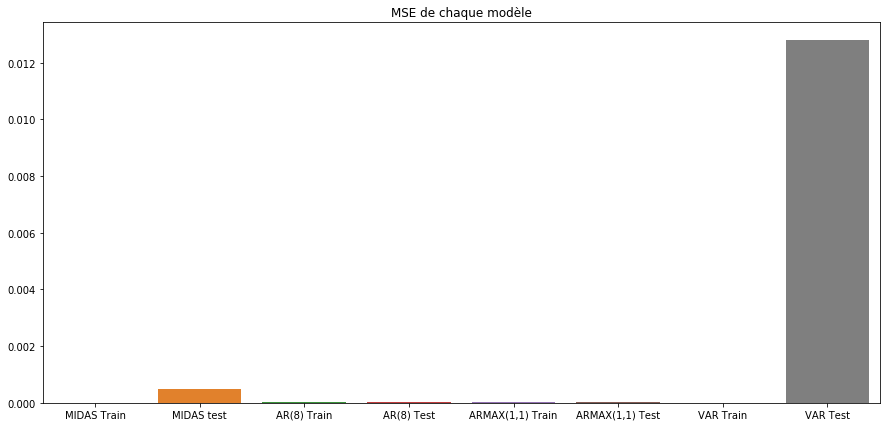

In [109]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['MIDAS Train','MIDAS test','AR(8) Train','AR(8) Test', 'ARMAX(1,1) Train', 'ARMAX(1,1) Test','VAR Train', 'VAR Test'],y=[train_mse_midas,test_mse_midas,train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx,train_mse_var,test_mse_var],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse.png')

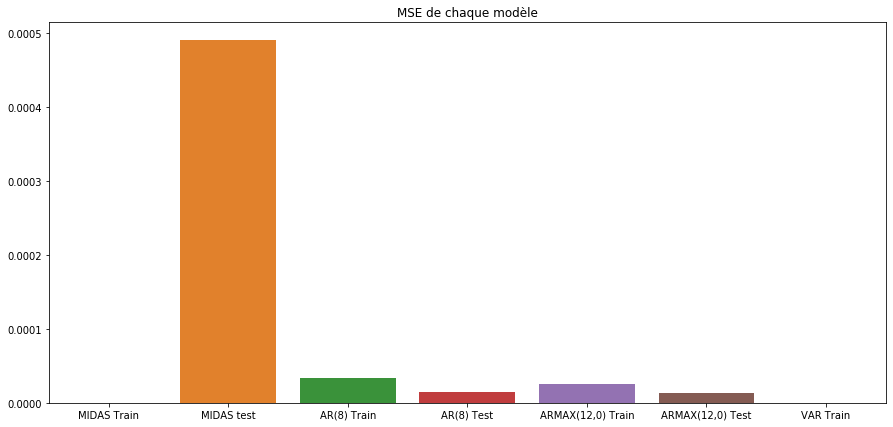

In [110]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['MIDAS Train','MIDAS test','AR(8) Train','AR(8) Test', 'ARMAX(12,0) Train', 'ARMAX(12,0) Test','VAR Train'],y=[train_mse_midas,test_mse_midas,train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx,train_mse_var],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse2.png')

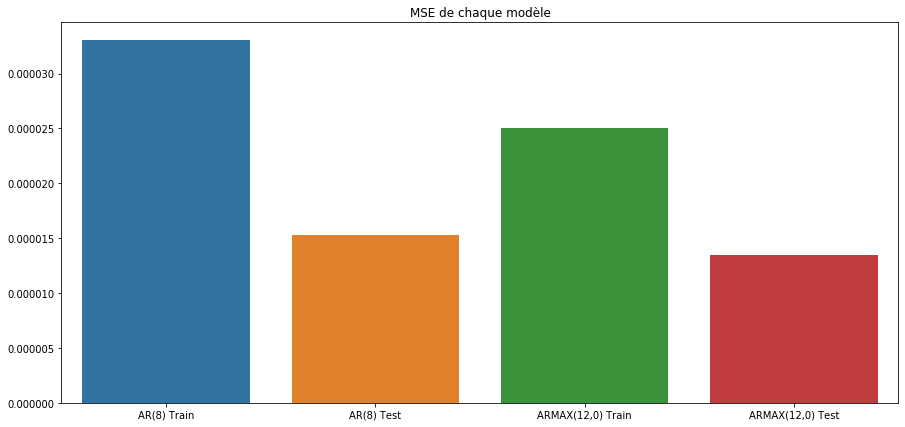

In [111]:
figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['AR(8) Train','AR(8) Test', 'ARMAX(12,0) Train', 'ARMAX(12,0) Test'],y=[train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse3.png')

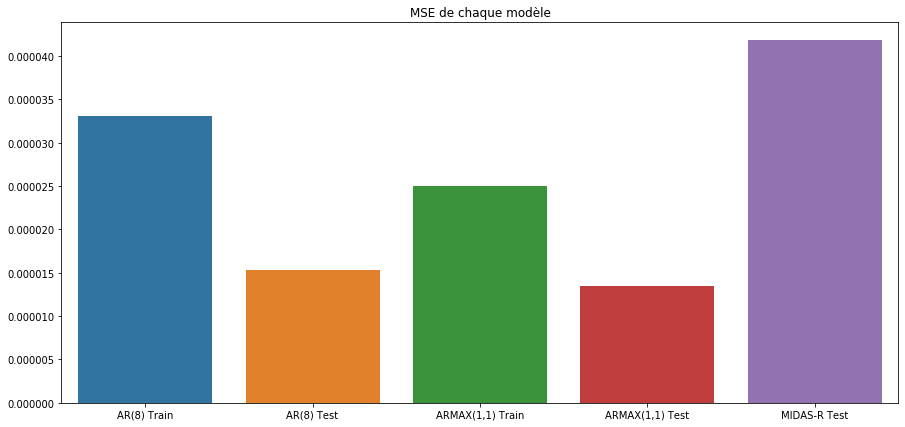

In [112]:
test_mse_midasr = 4.178053e-05

figure, axe = plt.subplots(figsize=(15,7))

sns.barplot(x=['AR(8) Train','AR(8) Test', 'ARMAX(1,1) Train', 'ARMAX(1,1) Test','MIDAS-R Test'],y=[train_mse_ar,test_mse_ar,train_mse_sarx,test_mse_sarx,test_mse_midasr],ax=axe)
axe.set_title('MSE de chaque modèle')
plt.show()
figure.savefig('modelsmse4.png')

### Visualisation des résultats intégrés

In [113]:
yty_var_tot = pd.DataFrame({'Variations de la consommation':var, 'Date':list(conso.index)[4:]})
yty_var_tot = yty_var_tot.set_index('Date').loc['2011T1':].iloc[:,0].shift(1).iloc[1:]

yty_var_tot.index = lesdates[np.arange(2,len(lesdates),3)]
yty_var_tot3 = pd.DataFrame()
for i in range(len(X_selectb)):
    yty_var_tot3[i] = pd.Series(np.float64(yty_var_tot.iloc[i//3]))
yty_var_tot3 = yty_var_tot3.T[0]
yty_var_tot3.index = X_selectb.index

TypeError: float() argument must be a string or a number, not 'RegressionResultsWrapper'

In [114]:
figure, axe = plt.subplots(figsize=(15,7))

axe.plot(yty_var_tot3.shift(-3), marker = '.', linestyle='', color='darkblue', label='Actual')

axe.plot((toreallyplot+yty_var_tot3).dropna(), color='orange', label='MIDAS')
axe.plot((toreallyplot2+yty_var_tot3).dropna(), color='orange')


axe.plot((artrainprediction+yty_var_tot).dropna(), color='green' , label='AR(8)')
axe.plot((artestprediction+yty_var_tot).dropna(), color='green')

axe.plot(sarima.get_prediction(start=0,end=34,
endog=yty_var_tot,
exog=X_selectb_agg.iloc[len(Y_train):,:]).predicted_mean+yty_var_tot, label='ARMAX(1,1)')

axe.plot(var.predict(regressors)+yty_var_tot, label='VAR')

axe.axvline(Y_train.index[-1], color = 'darkred')

plt.legend()
plt.show()

ZeroDivisionError: integer division or modulo by zero

### Résultats avec inputs CVS

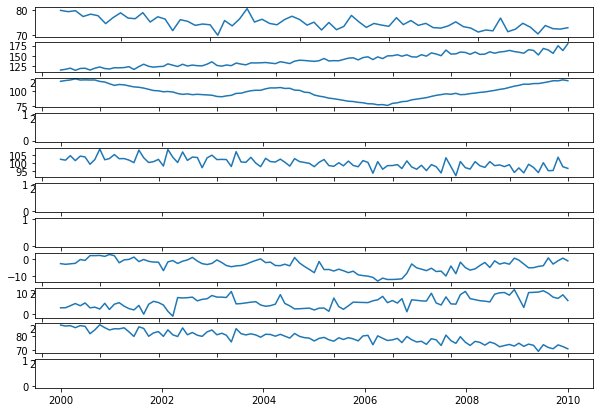

In [115]:
X_selecta = X[selectionCVS].iloc[-105:,:] # On calcule en yty_var
X_selecta.index = lesdates
figg, axx = plt.subplots(len(X_selecta.columns), figsize=(10,7))
for i in range(len(X_selecta.columns)):
    axx[i].plot(X_selecta.iloc[:,i])
plt.show()

Nous allons dropper les colonnes NaN.

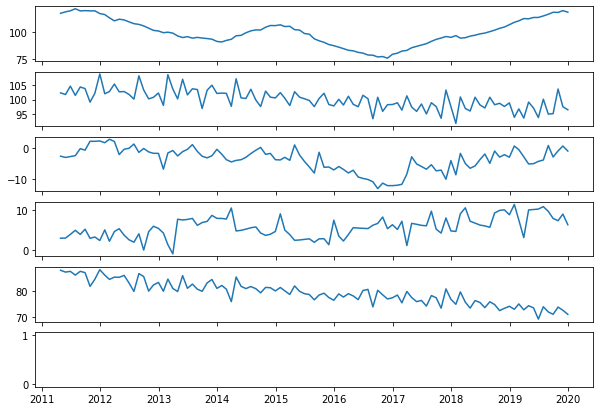

In [116]:
X_selecta = X_selecta.drop(['Information et communication, situation de la trésorerie en fin de mois (CVS)','Transports, hébergement et restauration, prévisions d\'évolution de la demande globale à 1 mois (CVS)','Transports routiers de fret et par conduites, évolution de l\'activité par rapport au mois précédent (CVS)'], axis=1)
X_selecta = X_selecta.iloc[:,2:]
figg, axx = plt.subplots(len(X_selecta.columns), figsize=(10,7), sharex = True)
for i in range(len(X_selecta.columns)):
    axx[i].plot(X_selecta.iloc[:,i])
plt.show()

In [117]:
regX = pd.DataFrame()
regX['Constante'] = pd.Series(np.ones(len(X_selectb)))
regX['Temps'] = pd.Series(np.arange(1,len(X_selectb)+1))
regX.index = X_selectb.index
ts = []
for i in range(len(X_selectb.columns)):
    ts.append((sm.OLS(X_selectb.iloc[:,i],regX).fit().pvalues < 0.05)) # On regarde pour chaque variable s'il y a une tendance déterministe


adftest = [] # On fait un test ADF pour chacune

for i in range(len(X_selectb.columns)):
    regressionmode = ''
    if ts[i][0] :
        regressionmode += 'c'
        if ts[i][1] :
            regressionmode += 't'
    else:
        regressionmode = 'nc'
    adftest.append(adfuller(X_selectb.iloc[:,i],regression = regressionmode, maxlag=24, autolag='t-stat')[1] < 0.05)

adftest

NameError: name 'adfuller' is not defined

Les séries CVS sont déjà stationnaires !

In [118]:
''' Calcul de omega '''

p = 4 # On fixe l'ordre de régression p, il faudrait enquêter sur les autocorrélations
k = len(X_selecta.columns)

Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
for t in np.arange(p,len(yty_var_tot)):
    z = [1]
    for i in np.arange(1,p): # On rajoute les Y_3(t-i)
        z.append(np.float64(yty_var_tot.iloc[t-i]))
    for j in range(k): # On rajoute les X_3t-i
        for l in np.arange(0,3*p):
            z.append(np.float64(X_selecta.iloc[(3*t)-l,j])) # Vérifier qu'on a les bons index
    Z[t] = pd.Series(z)

sumdesign = Z @ Z.T
inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) # Ensuite, on calcule la somme des matrices de design et son inverse
secondfactor = pd.DataFrame(Z.values @ yty_var_tot.iloc[p:].values) # On calcule également la somme des produits Z_3t' par Y_3t

omega = inv_sumdesign @ secondfactor 

TypeError: float() argument must be a string or a number, not 'RegressionResultsWrapper'

In [119]:
''' Calcul des résidus sur l'échantillon d'entraînement '''

fcst = pd.DataFrame()
for t in np.arange(p,len(yty_var_tot)):
    fcst[t] = omega.T @ Z[t]

fcst = fcst.T
fcst.index = yty_var_tot.index[p:]

epsilon = yty_var_tot - fcst[0]

KeyError: 4

In [120]:
figure, axe = plt.subplots(figsize=(20,8))
axe.plot(fcst.index, fcst)
axe.plot(fcst.index, yty_var_tot[p:]-0.002) # On décale un tout petit peu pour voir qqch
plt.show()

ZeroDivisionError: integer division or modulo by zero

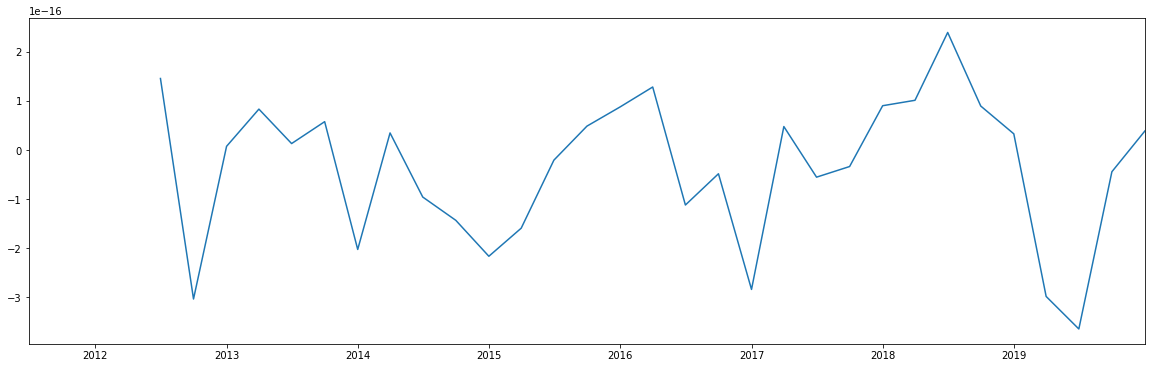

In [121]:
epsilon.plot(figsize=(20,6))
plt.show()

In [122]:
Y_train = yty_var_tot.iloc[:25]
Y_test = yty_var_tot.iloc[25:]
X_train = X_selecta.iloc[:75,:]
X_test = X_selecta.iloc[75:,:]

In [123]:
''' Calcul des omegas de l'approche directe '''

p = 4 # On fixe l'ordre de régression p, il faudrait enquêter sur les autocorrélations
k = len(X_selecta.columns)

Zs = []
omegas = []
for situation in range(4):

    Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
    for t in np.arange(p,len(yty_var_tot)):
        z = [1]
        for i in np.arange(1,p): # On rajoute les Y_3(t-i)
            z.append(np.float64(yty_var_tot.iloc[t-i]))
        for j in range(k): # On rajoute les X_3t-i
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selecta.iloc[(3*t)-situation-l,j])) # Vérifier qu'on a les bons index
        Z[t] = pd.Series(z)
    Zs.append(Z)
    sumdesign = Z @ Z.T
    inv_sumdesign = pd.DataFrame(np.linalg.pinv(sumdesign.values)) # Ensuite, on calcule la somme des matrices de design et son inverse
    secondfactor = pd.DataFrame(Z.values @ yty_var_tot.iloc[p:].values) # On calcule également la somme des produits Z_3t' par Y_3t

    omega = inv_sumdesign @ secondfactor
    omegas.append(omega)

Zstest = []
for situation in range(4):

    Z = pd.DataFrame() # Pour tout t, on construit Z_3t dans une liste
    for t in np.arange(len(Y_train),len(yty_var_tot)):
        z = [1]
        for i in np.arange(1,p): # On rajoute les Y_3(t-i)
            z.append(np.float64(yty_var_tot.iloc[t-i]))
        for j in range(k): # On rajoute les X_3t-i
            for l in np.arange(0,3*p):
                z.append(np.float64(X_selecta.iloc[(3*t)-situation-l,j])) # Vérifier qu'on a les bons index
        Z[t] = pd.Series(z)
    Zstest.append(Z)

TypeError: float() argument must be a string or a number, not 'RegressionResultsWrapper'

In [124]:
toplot = []

for t in np.arange(p,len(Y_train)):
    for situation in range(3):
        toplot.append(Zs[2-situation][t] @ omegas[2-situation])

toreallyplot = pd.Series([toplot[i][0] for i in range(len(toplot))])
toreallyplot.index = X_train.index[3*p:]

toplot2 = []

for t in range(len(yty_var_tot)-len(Y_train)):
    for situation in range(3):
        toplot2.append(Zstest[2-situation].iloc[:,t] @ omegas[2-situation])

toreallyplot2 = pd.Series([toplot2[i][0] for i in range(len(toplot2))])
toreallyplot2.index = X_test.index


AR8 = sm.tsa.SARIMAX(Y_train, order=(8,0,0)).fit()
artrainprediction = AR8.get_prediction().predicted_mean
artestprediction = AR8.get_forecast(steps=len(Y_test)).predicted_mean

liste1 = []
liste2 = []
for elt in artrainprediction:
    for i in range(3):
        liste1.append(elt)

for elt in artestprediction:
    for i in range(3):
        liste2.append(elt)

artrainprediction = pd.Series(liste1)
artestprediction = pd.Series(liste2)
artrainprediction.index = X_train.index
artestprediction.index = X_test.index


figure, axe = plt.subplots(figsize=(15,7))
axe.plot(yty_var_tot, color='darkblue', label='Actual')
axe.plot(toreallyplot, color='orange', label='MIDAS')
axe.plot(toreallyplot2, color='orange')
axe.plot(artrainprediction, color='green' , label='AR(8)')
axe.plot(artestprediction, color='green')
axe.axvline(Y_train.index[-1], color = 'darkred')
plt.legend()
plt.show()

IndexError: list index out of range

In [125]:
import pyfile